In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (  # MaxAbsScaler,; StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from xgboost import DMatrix, XGBRegressor, plot_importance, train

plt.rcParams["figure.figsize"] = [17, 6]
plt.rcParams["figure.dpi"] = 100
# shap.initjs()
from ipywidgets import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
rivers = [
    "BEAS",
    "SATLUJ",
    "GANGA",
    "YAMUNA",
    "MAHANADI",
    "GODAVARI",
    "KRISHNA",
    "CAUVERY",
    "BRAHMAPUTRA",
]
states = [
    "UTTARAKHAND",
    "HIMACHAL PRADESH",
    "HARYANA",
    "DELHI",
    "UTTAR PRADESH",
    "PUNJAB",
    "BIHAR",
    "WEST BENGAL",
    "ASSAM",
    "CHHATTISGARH",
    "ODISHA",
    "MAHARASHTRA",
    "ANDHRA PRADESH",
    "KARNATAKA",
    "TAMIL NADU",
    "TELANGANA",
    "JHARKHAND",
    "INTER-STATE",
]

In [3]:
df_1 = (
    pd.read_csv(f"./WQ 2012_2021.csv")
    .query("YEAR != 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR", "RIVER", "STATE"])
)
cols = df_1.columns.str.replace(" ", "_").tolist()
df_1.columns = cols
df_1 = df_1[cols[24:] + cols[2:24:3]].bfill()
cols = df_1.columns.to_list()

predict = cols.index("T_AVG")

X_split = (
    cols[: predict - len(cols)]
    + cols[predict + 1 if predict != len(cols) else len(cols) :]
)
y_split = cols[predict - len(cols)]

X = df_1[X_split]
y = df_1[[y_split]]


X.loc[:, X_split] = MinMaxScaler().fit_transform(X)
y.loc[:, y_split] = MinMaxScaler().fit_transform(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Graphs

In [4]:
# target = 1
# X_train, X_valid, y_train, y_valid = get_data(target)
# d_train = DMatrix(X_train, label=y_train)
# d_test = DMatrix(X_valid, label=y_valid)
# params = {
#     "eta": 0.01,
#     "objective": "binary:logistic",
#     "subsample": 0.5,
#     "base_score": np.mean(X_train),
#     "eval_metric": "logloss",
# }
# model = train(
#     params,
#     d_train,
#     10000,
#     evals=[(d_test, "test")],
#     verbose_eval=100,
#     early_stopping_rounds=50,
# )

In [5]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)
# shap.force_plot(explainer.expected_value, shap_values[:1], X_train[:1])

In [6]:
# shap.summary_plot(shap_values, X_train, alpha=0.5, title=feature_target[target])

In [5]:
# (River, State) -> x-axis: Features, y-axis: RMSE value for prediction of features.

df: pd.core.frame.DataFrame = (
    pd.read_csv(f"./WQ 2012_2021.csv")
    .query("YEAR != 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR"])
    .bfill()
)
df = pd.concat([df.iloc[:, :2], df.iloc[:, 4::3]], axis=1)
feature_target = df.columns[2:]
df[feature_target] = MinMaxScaler().fit_transform(df.iloc[:, 2:])


def get_data(target_name: str, grouped: bool = False):
    f = (
        lambda x: x.groupby(["RIVER", "STATE"]).mean()
        if grouped
        else x.drop(columns=["RIVER", "STATE"])
    )
    return tuple(
        map(
            f,
            train_test_split(
                df.drop(columns=[target_name]),
                df[[target_name, "RIVER", "STATE"]],
                random_state=0,
                test_size=0.1,
            ),
        )
    )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


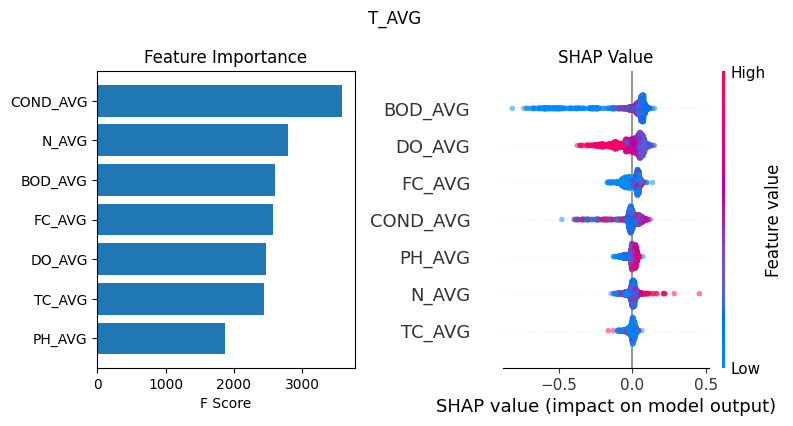

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


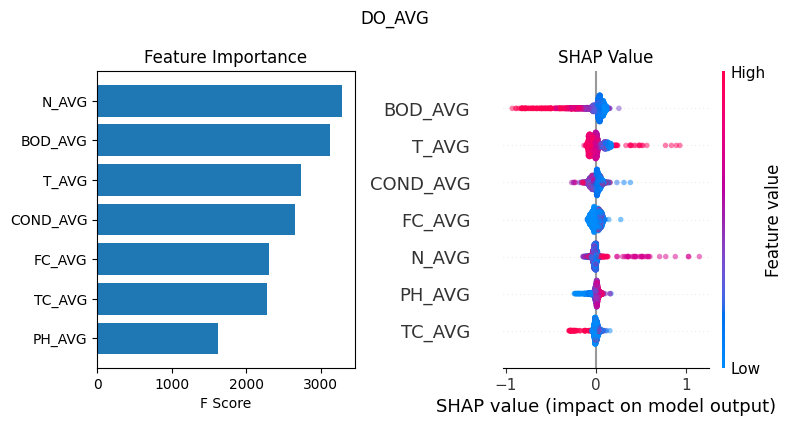

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


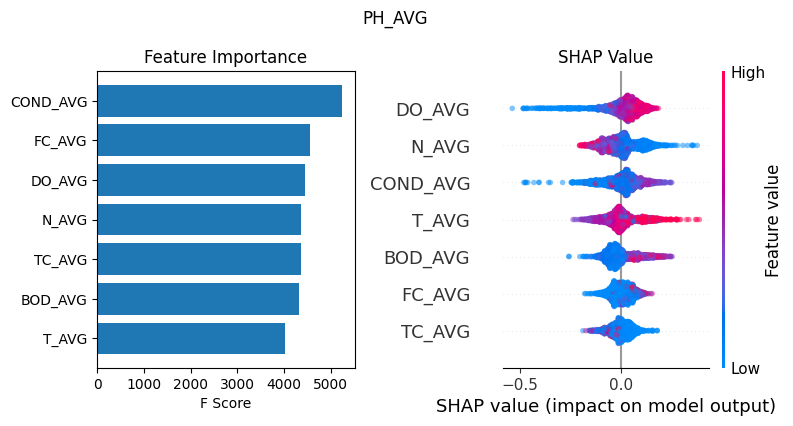

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


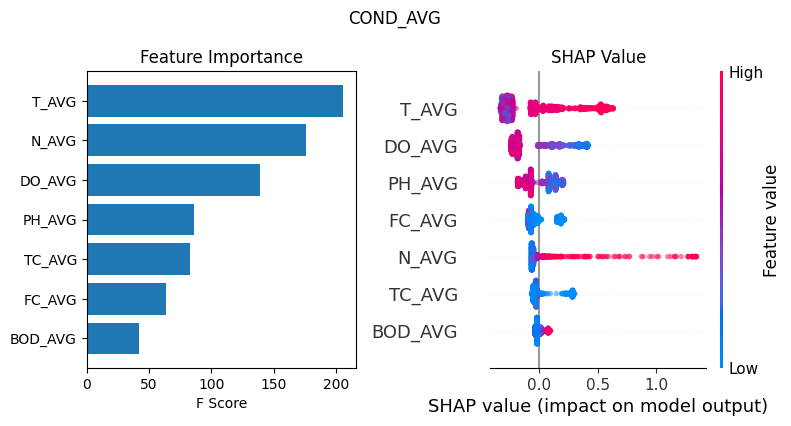

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


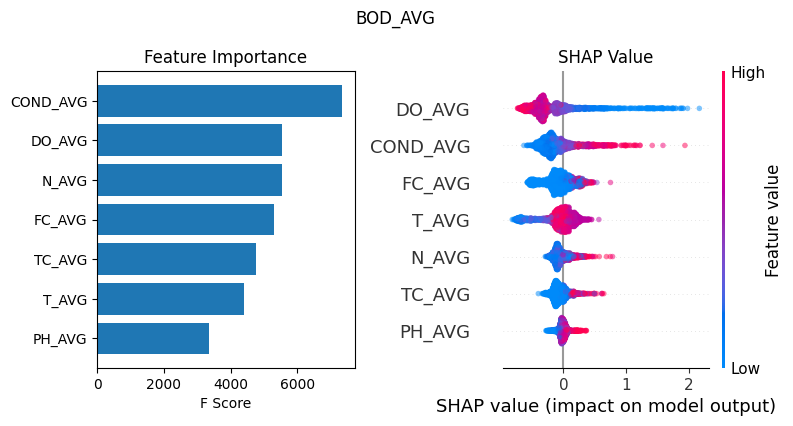

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


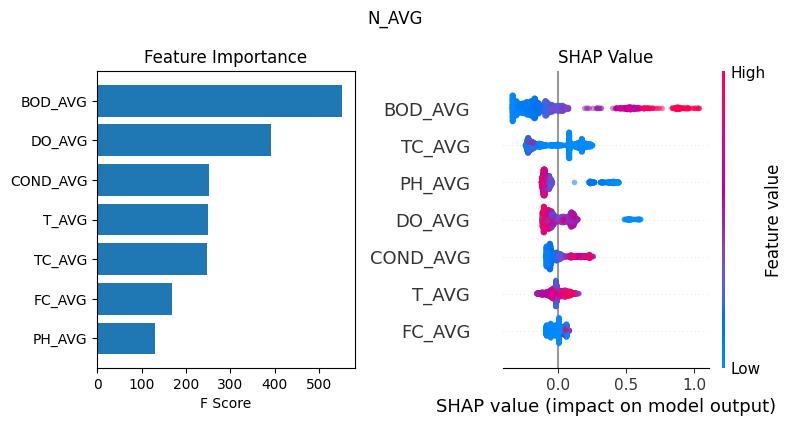

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


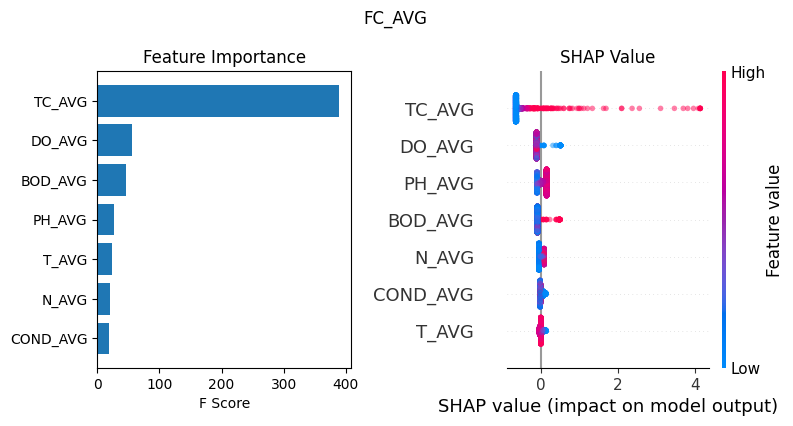

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


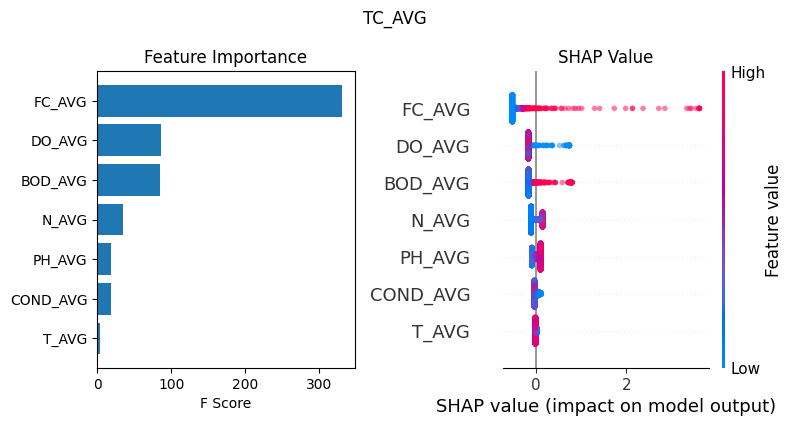

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


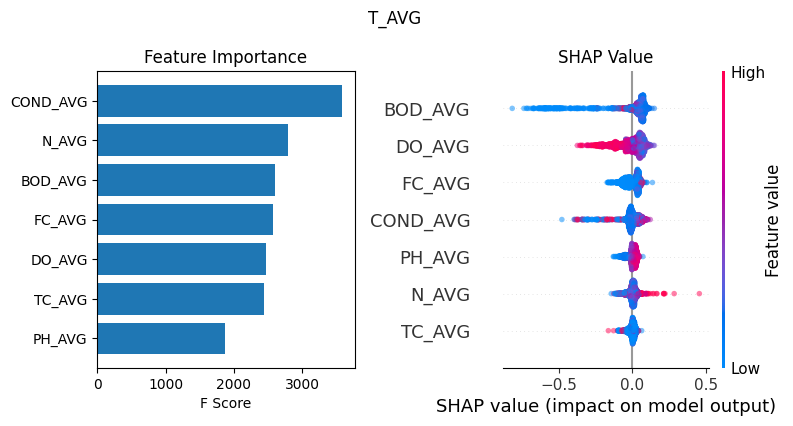

In [7]:
models = {}


for target, target_name in enumerate(feature_target):
# def plot_explain(target_name):
    X_train, X_valid, y_train, y_valid = get_data(target_name)
    d_train = DMatrix(X_train, label=y_train)
    d_valid = DMatrix(X_valid, label=y_valid)
    params = {
        "eta": 0.01,
        "objective": "binary:logistic",
        "subsample": 0.5,
        "base_score": np.mean(X_train),
        "eval_metric": "logloss",
    }
    model = train(
        params,
        d_train,
        10000,
        evals=[(d_valid, "test")],
        verbose_eval=000,
        early_stopping_rounds=50,
    )
    f_score = dict(sorted(model.get_fscore().items(), key=lambda item: item[1]))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    fig, ax = plt.subplots(1, 2)
    plt.suptitle(target_name)
    plt.subplot(1, 2, 1)
    plt.title("Feature Importance")
    plt.barh(list(f_score.keys()), list(f_score.values()))
    plt.xlabel("F Score")
    plt.subplot(1, 2, 2)
    plt.title("SHAP Value")
    shap.summary_plot(shap_values, X_train, alpha=0.5, title=target_name)
    fig.savefig(f"./relations_between_features/{target_name}.png")
    models[target_name] = {"model": model, "shap": shap_values, "fi": f_score}


plot_explain("T_AVG")

In [8]:
df_test: pd.core.frame.DataFrame = (
    pd.read_csv(f"./WQ 2012_2021.csv")
    .query("YEAR == 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR"])
    .bfill()
    .groupby(["RIVER", "STATE"])
    .mean()
)
index = df_test.index
df_test = df_test.iloc[:, 2::3]
feature_target = df_test.columns
df_test[feature_target] = MinMaxScaler().fit_transform(df_test)

error = {}

for r, s in df_test.index:
    err = []
    for target, target_name in enumerate(feature_target):
        model_p = models[target_name]["model"]

        X = df_test.drop(columns=[target_name]).loc[r, s].to_frame().transpose()
        y = df_test[target_name].loc[r, s]
        d_test = DMatrix(X)
        o = model_p.predict(d_test)
        rse = np.linalg.norm(o - y)
        err.append((target_name, rse))
    error[(r, s)] = err

In [9]:
river_state = (
    pd.read_csv("./WQ 2012_2021.csv")
    .query("YEAR == 2021")
    .drop(columns=["LOCATION", "CODE"])
    .groupby(["RIVER", "STATE"])
    .mean()
    .index.to_list()
)
dict_river_state = {}
for r, s in river_state:
    if r in dict_river_state:
        dict_river_state[r].append(s)
        continue
    dict_river_state[r] = [s]

In [10]:
def plot_error(river, state):
    plt.close()
    X = [x[0] for x in error[(river, state)]]
    y = [x[1] for x in error[(river, state)]]
    plt.bar(X, y)
    plt.scatter(X, y)
    plt.title(f"{river}\n{state}")
    plt.show()

In [11]:
river_d = widgets.Dropdown(
    options=list(dict_river_state.keys()),
    value=list(dict_river_state.keys())[0],
    description="River:",
)

state_d = widgets.Dropdown(
    options=list(dict_river_state.values())[0],
    value=list(dict_river_state.values())[0][0],
    description="State:",
)


def update_state(change):
    state_d.options = dict_river_state[river_d.value]


river_d.observe(update_state, "value")

widgets.interact(plot_error, river=river_d, state=state_d)

interactive(children=(Dropdown(description='River:', options=('BEAS', 'BRAHMAPUTRA', 'CAUVERY', 'GANGA', 'GODA…

<function __main__.plot_error(river, state)>

In [12]:
models = {}


# for target, target_name in enumerate(feature_target):
def plot_explain(target_name):
    plt.close()
    X_train, X_valid, y_train, y_valid = get_data(target_name)
    d_train = DMatrix(X_train, label=y_train)
    d_valid = DMatrix(X_valid, label=y_valid)
    params = {
        "eta": 0.01,
        "objective": "binary:logistic",
        "subsample": 0.5,
        "base_score": np.mean(X_train),
        "eval_metric": "logloss",
    }
    model = train(
        params,
        d_train,
        10000,
        evals=[(d_valid, "test")],
        verbose_eval=000,
        early_stopping_rounds=50,
    )
    f_score = dict(sorted(model.get_fscore().items(), key=lambda item: item[1]))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    fig, ax = plt.subplots(1, 2)
    plt.suptitle(target_name)
    plt.subplot(1, 2, 1)
    plt.title("Feature Importance")
    plt.barh(list(f_score.keys()), list(f_score.values()))
    plt.xlabel("F Score")
    plt.subplot(1, 2, 2)
    plt.title("SHAP Value")
    shap.summary_plot(shap_values, X_train, alpha=0.5, title=target_name)
    fig.savefig(f"./relations_between_features/{target_name}.png")
    models[target_name] = {"model": model, "shap": shap_values, "fi": f_score}

In [13]:
features = widgets.Dropdown(
    options=feature_target, value=feature_target[0], description="Feature: "
)

widgets.interact(plot_explain, target_name=features)

interactive(children=(Dropdown(description='Feature: ', options=('T_AVG', 'DO_AVG', 'PH_AVG', 'COND_AVG', 'BOD…

<function __main__.plot_explain(target_name)>